<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/main/Feature_Selection_RFECV_%26_SFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INICIANDO ANÁLISIS COMPLETO - SVM
Dataset cargado: 10000 muestras, 48 características
Muestra para SFS: 2000 ejemplos

BASELINE SVM (todas las características)
F1-Score Baseline: 0.9737

RFECV SVM (Recursive Feature Elimination)
Usando SVM lineal para RFECV (requiere coeficientes)
Tiempo RFECV: 69.7s
Características: 32 de 48 (33.3% reducción)
F1-Score: 0.9731

SFS SVM (Sequential Feature Selection)
Tiempo SFS: 274.7s
Características: 15 de 48 (68.8% reducción)
F1-Score: 0.9153

RESULTADOS SVM
         Método  Num_Características  Recall  Precision  F1_Score  Accuracy  \
0  SVM Baseline                   48   0.981     0.9665    0.9737    0.9735   
1   SVM + RFECV                   32   0.976     0.9702    0.9731    0.9730   
2     SVM + SFS                   15   0.935     0.8965    0.9153    0.9135   

   Reducción_%  Tiempo_s  
0       0.0000    0.0000  
1      33.3333   69.6808  
2      68.7500  274.7411  

MEJOR MÉTODO:
   Método: SVM Baseline
   Características: 48 de 48 (0.0% re

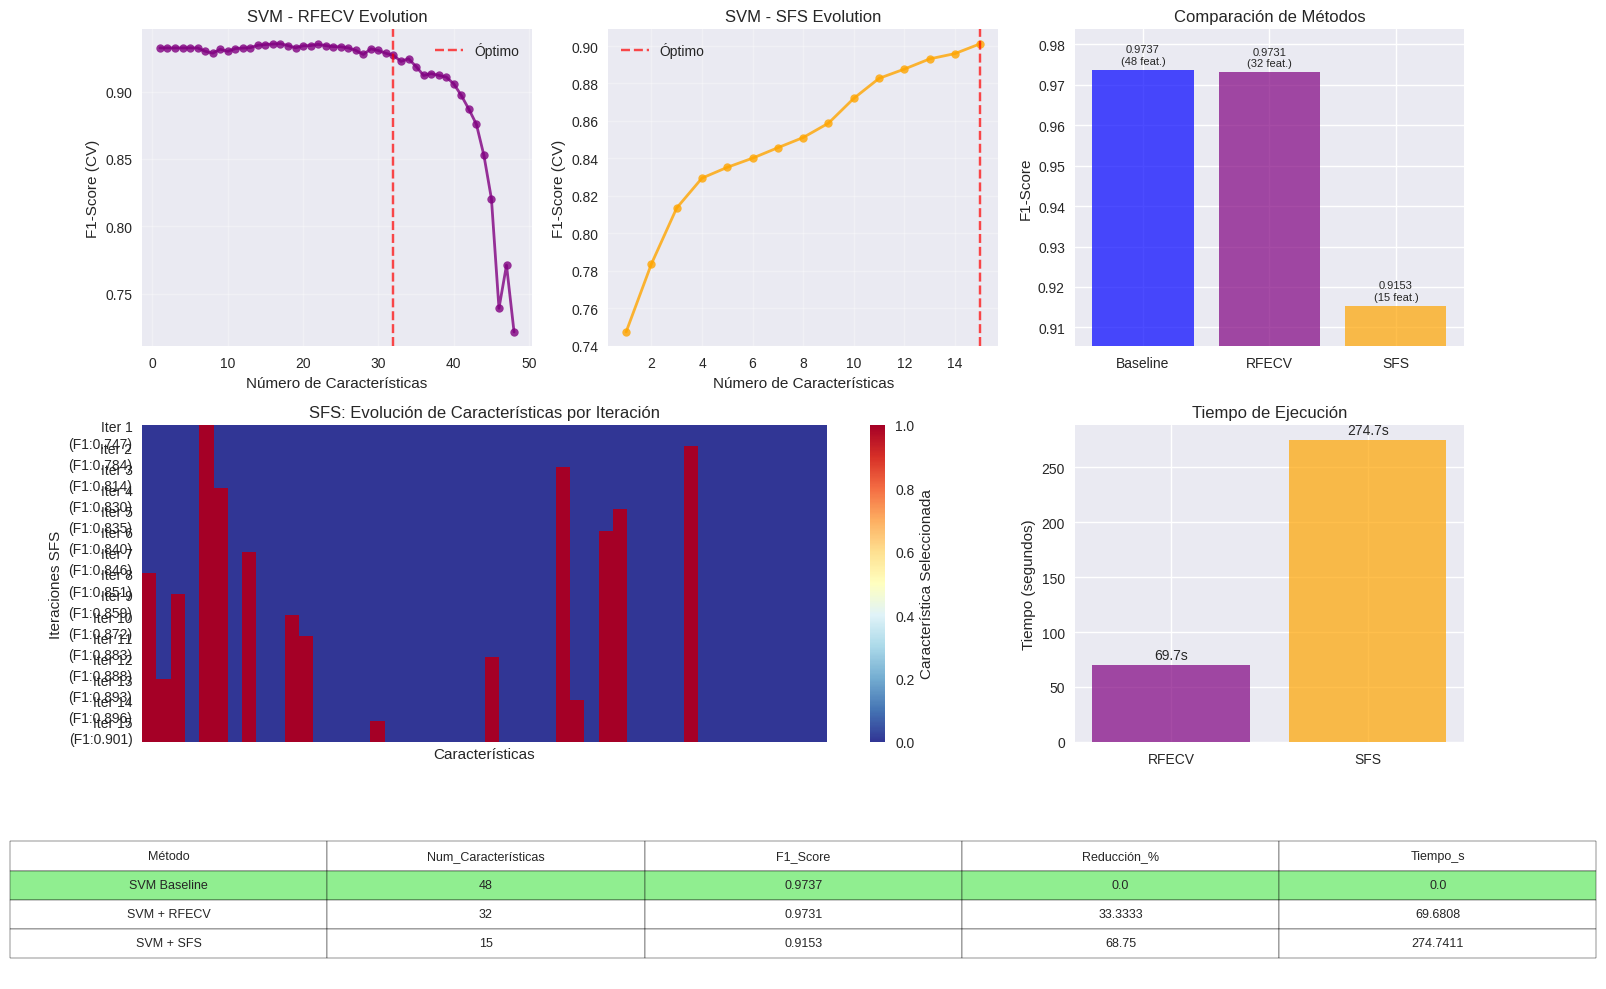


TIEMPO TOTAL: 344.4 segundos
INICIANDO ANÁLISIS COMPLETO - RF
Dataset cargado: 10000 muestras, 48 características
Muestra para SFS: 3000 ejemplos

BASELINE RF (todas las características)
F1-Score Baseline: 0.9875

RFECV RF (Recursive Feature Elimination)
Tiempo RFECV: 131.3s
Características: 46 de 48 (4.2% reducción)
F1-Score: 0.9870

SFS RF (Sequential Feature Selection)
Tiempo SFS: 1532.1s
Características: 20 de 48 (58.3% reducción)
F1-Score: 0.9835

RESULTADOS RF
        Método  Num_Características  Recall  Precision  F1_Score  Accuracy  \
0  RF Baseline                   48   0.988     0.9870    0.9875    0.9875   
1   RF + RFECV                   46   0.986     0.9880    0.9870    0.9870   
2     RF + SFS                   20   0.981     0.9859    0.9835    0.9835   

   Reducción_%   Tiempo_s  
0       0.0000     0.0000  
1       4.1667   131.2702  
2      58.3333  1532.1235  

MEJOR MÉTODO:
   Método: RF Baseline
   Características: 48 de 48 (0.0% reducción)
   F1-Score: 0.9875

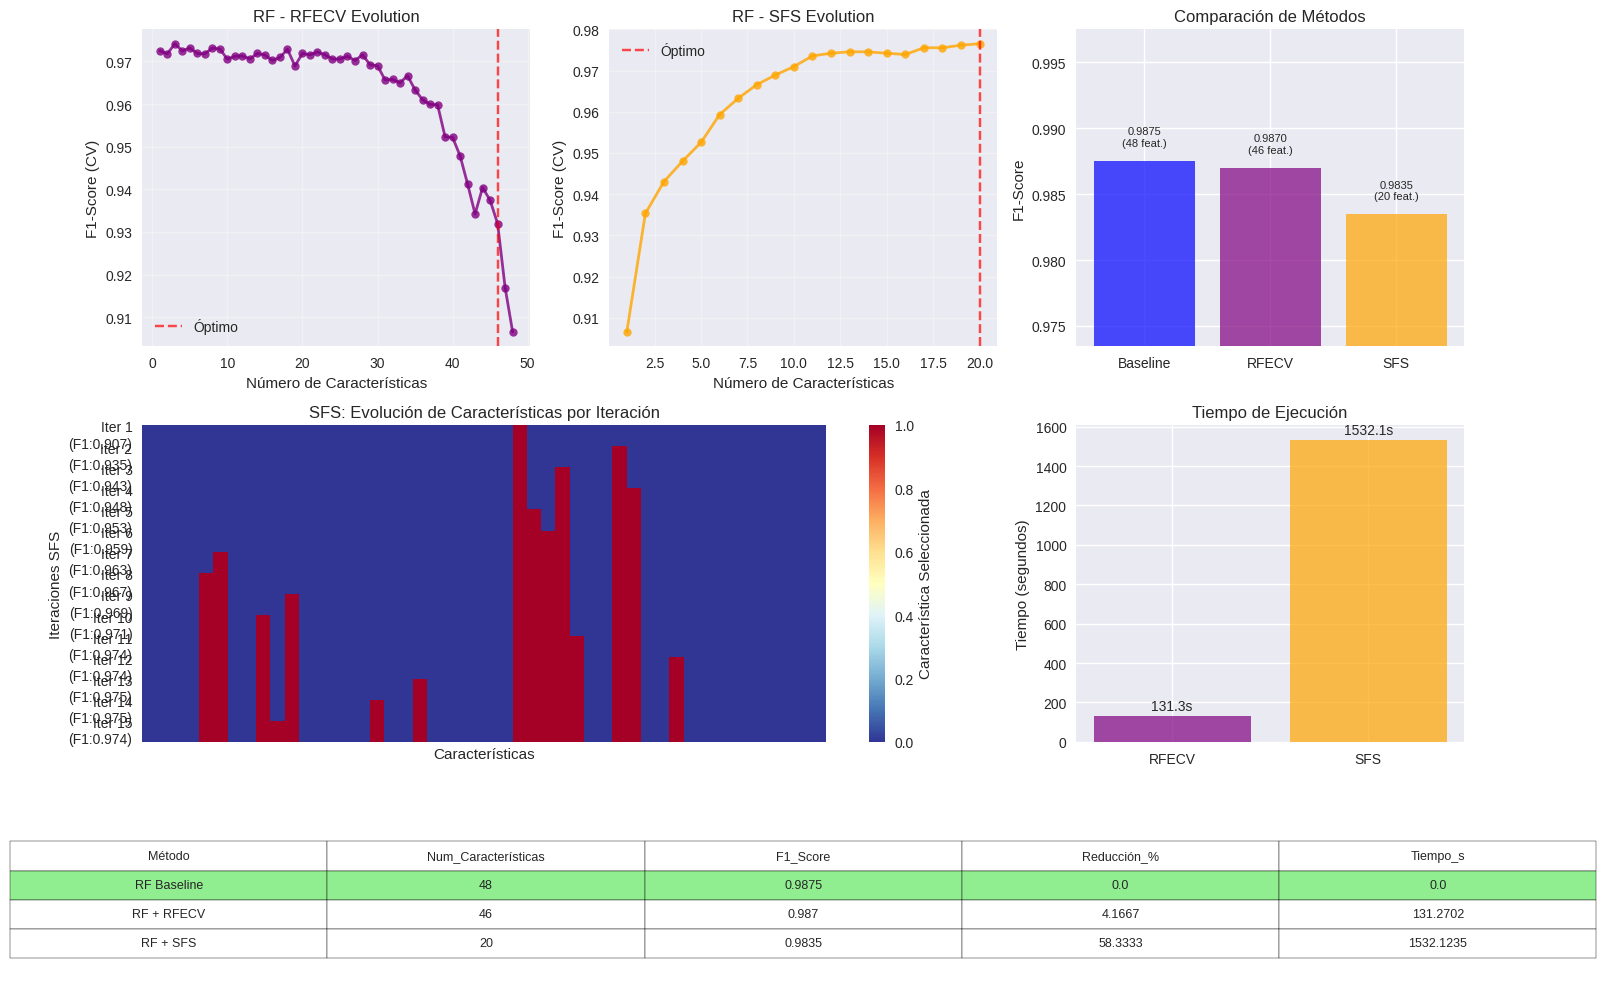


TIEMPO TOTAL: 1663.4 segundos


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
import time
from typing import Dict, List, Tuple, Optional
warnings.filterwarnings('ignore')

class FeatureSelector:
    """
    Clase para realizar selección de características usando RFECV y SFS
    con parámetros completos de los modelos optimizados.
    """

    def __init__(self,
                 estimator_type: str = 'svm',
                 estimator_params: Dict = None,
                 test_size: float = 0.2,
                 cv_folds: int = 3,
                 random_state: int = 42,
                 sample_size: int = 2000):
        """
        Inicializa el selector de características.

        Args:
            estimator_type: Tipo de estimador ('svm' o 'rf')
            estimator_params: Parámetros del estimador
            test_size: Tamaño del conjunto de prueba
            cv_folds: Número de folds para validación cruzada
            random_state: Semilla aleatoria
            sample_size: Tamaño de muestra para SFS
        """
        self.estimator_type = estimator_type.lower()
        self.estimator_params = estimator_params or {}
        self.test_size = test_size
        self.cv_folds = cv_folds
        self.random_state = random_state
        self.sample_size = sample_size

        # Resultados almacenados
        self.results = {}
        self.feature_evolution = {}
        self.timing_info = {}

        # Configurar estimadores
        self._setup_estimators()

        # Configurar validación cruzada
        self.cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    def _setup_estimators(self):
        """Configura los estimadores según el tipo especificado."""
        if self.estimator_type == 'svm':
            # Parámetros por defecto para SVM
            default_params = {
                'C': 14.403910932208483,
                'kernel': 'rbf',
                'shrinking': True,
                'class_weight': None,
                'gamma': 'scale',
                'random_state': self.random_state
            }
            default_params.update(self.estimator_params)

            # Estimador original (RBF)
            self.estimator_original = SVC(**default_params)

            # Para RFECV y SFS: usar SVM lineal con parámetros completos
            linear_params = default_params.copy()
            linear_params['kernel'] = 'linear'
            linear_params.pop('gamma', None)  # gamma no aplica para kernel lineal

            self.estimator_selection = SVC(**linear_params)

        elif self.estimator_type == 'rf':
            # Parámetros por defecto para Random Forest
            default_params = {
                'n_estimators': 157,
                'max_depth': 27,
                'min_samples_split': 2,
                'min_samples_leaf': 1,
                'max_features': 'log2',
                'bootstrap': False,
                'class_weight': 'balanced',
                'random_state': self.random_state,
                'n_jobs': -1
            }
            default_params.update(self.estimator_params)

            # Mismo estimador para original y selección
            self.estimator_original = RandomForestClassifier(**default_params)
            self.estimator_selection = RandomForestClassifier(**default_params)

    def load_data(self, url: str = None, X: pd.DataFrame = None, y: pd.Series = None):
        """
        Carga y prepara los datos.

        Args:
            url: URL del dataset
            X: Features (si se pasan directamente)
            y: Target (si se pasa directamente)
        """
        if url:
            df = pd.read_csv(url).drop(columns=["id"])
            self.X = df.drop(columns=["CLASS_LABEL"])
            self.y = df["CLASS_LABEL"]
        else:
            self.X = X
            self.y = y

        # División de datos
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, stratify=self.y, test_size=self.test_size, random_state=self.random_state
        )

        # Escalamiento si es necesario
        if self.estimator_type == 'svm':
            self.scaler = StandardScaler()
            self.X_train_scaled = self.scaler.fit_transform(self.X_train)
            self.X_test_scaled = self.scaler.transform(self.X_test)
        else:
            self.X_train_scaled = self.X_train.values
            self.X_test_scaled = self.X_test.values

        # Muestra para SFS
        sample_size = min(self.sample_size, len(self.X_train))
        idx_sample = np.random.choice(len(self.X_train), sample_size, replace=False)
        self.X_train_sample = self.X_train_scaled[idx_sample]
        self.y_train_sample = self.y_train.iloc[idx_sample]

        print(f"Dataset cargado: {self.X.shape[0]} muestras, {self.X.shape[1]} características")
        print(f"Muestra para SFS: {sample_size} ejemplos")

    def evaluate_model(self, estimator, X_train_data, X_test_data, y_train, y_test) -> Dict:
        """Evalúa un modelo y retorna las métricas."""
        estimator.fit(X_train_data, y_train)
        y_pred = estimator.predict(X_test_data)

        return {
            'recall': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'accuracy': accuracy_score(y_test, y_pred)
        }

    def run_baseline(self):
        """Ejecuta evaluación baseline."""
        print(f"\nBASELINE {self.estimator_type.upper()} (todas las características)")

        self.baseline_metrics = self.evaluate_model(
            self.estimator_original,
            self.X_train_scaled,
            self.X_test_scaled,
            self.y_train,
            self.y_test
        )

        print(f"F1-Score Baseline: {self.baseline_metrics['f1']:.4f}")

    def run_rfecv(self):
        """Ejecuta RFECV con seguimiento detallado."""
        print(f"\nRFECV {self.estimator_type.upper()} (Recursive Feature Elimination)")
        if self.estimator_type == 'svm':
            print("Usando SVM lineal para RFECV (requiere coeficientes)")

        start_time = time.time()

        # RFECV con modelo completo
        self.rfecv = RFECV(
            estimator=self.estimator_selection,
            step=1,
            cv=self.cv,
            scoring="f1",
            n_jobs=1
        )
        self.rfecv.fit(self.X_train_sample, self.y_train_sample)

        # Aplicar selección al dataset completo
        if self.estimator_type == 'svm':
            X_train_rfecv = self.X_train_scaled[:, self.rfecv.support_]
            X_test_rfecv = self.X_test_scaled[:, self.rfecv.support_]
        else:
            X_train_rfecv = self.X_train.iloc[:, self.rfecv.support_]
            X_test_rfecv = self.X_test.iloc[:, self.rfecv.support_]

        # Evaluación con modelo original
        self.rfecv_metrics = self.evaluate_model(
            self.estimator_original, X_train_rfecv, X_test_rfecv, self.y_train, self.y_test
        )

        self.timing_info['rfecv'] = time.time() - start_time

        # Almacenar información de evolución
        self.feature_evolution['rfecv'] = {
            'scores': list(self.rfecv.cv_results_["mean_test_score"]),
            'n_features': list(range(len(self.rfecv.cv_results_["mean_test_score"]), 0, -1)),
            'selected_features': np.sum(self.rfecv.support_),
            'feature_names': [self.X.columns[i] for i in range(len(self.X.columns)) if self.rfecv.support_[i]]
        }

        print(f"Tiempo RFECV: {self.timing_info['rfecv']:.1f}s")
        print(f"Características: {X_train_rfecv.shape[1]} de {self.X.shape[1]} ({100*(1-X_train_rfecv.shape[1]/self.X.shape[1]):.1f}% reducción)")
        print(f"F1-Score: {self.rfecv_metrics['f1']:.4f}")

    def run_sfs(self, max_features: int = None):
        """Ejecuta SFS con seguimiento detallado."""
        print(f"\nSFS {self.estimator_type.upper()} (Sequential Feature Selection)")

        start_time = time.time()

        if max_features is None:
            max_features = min(20 if self.estimator_type == 'rf' else 15, self.X.shape[1])

        # SFS con modelo completo
        self.sfs = SFS(
            self.estimator_selection,
            k_features=(1, max_features),
            forward=True,
            floating=False,
            scoring='f1',
            cv=self.cv,
            n_jobs=1
        )

        self.sfs.fit(self.X_train_sample, self.y_train_sample.values)

        # Aplicar selección al dataset completo
        selected_features_sfs = list(self.sfs.k_feature_idx_)

        if self.estimator_type == 'svm':
            X_train_sfs = self.X_train_scaled[:, selected_features_sfs]
            X_test_sfs = self.X_test_scaled[:, selected_features_sfs]
        else:
            X_train_sfs = self.X_train.iloc[:, selected_features_sfs]
            X_test_sfs = self.X_test.iloc[:, selected_features_sfs]

        # Evaluación con modelo original
        self.sfs_metrics = self.evaluate_model(
            self.estimator_original, X_train_sfs, X_test_sfs, self.y_train, self.y_test
        )

        self.timing_info['sfs'] = time.time() - start_time

        # Almacenar información de evolución SFS
        sfs_dict = self.sfs.get_metric_dict()
        self.feature_evolution['sfs'] = {
            'scores': [sfs_dict[k]['avg_score'] for k in sorted(sfs_dict.keys())],
            'n_features': [len(sfs_dict[k]['feature_idx']) for k in sorted(sfs_dict.keys())],
            'selected_features': len(selected_features_sfs),
            'feature_names': [self.X.columns[i] for i in selected_features_sfs],
            'iteration_details': sfs_dict
        }

        print(f"Tiempo SFS: {self.timing_info['sfs']:.1f}s")
        print(f"Características: {len(selected_features_sfs)} de {self.X.shape[1]} ({100*(1-len(selected_features_sfs)/self.X.shape[1]):.1f}% reducción)")
        print(f"F1-Score: {self.sfs_metrics['f1']:.4f}")

    def generate_results_table(self) -> pd.DataFrame:
        """Genera tabla de resultados completa."""
        self.results_df = pd.DataFrame({
            'Método': [f'{self.estimator_type.upper()} Baseline',
                      f'{self.estimator_type.upper()} + RFECV',
                      f'{self.estimator_type.upper()} + SFS'],
            'Num_Características': [
                self.X.shape[1],
                self.feature_evolution['rfecv']['selected_features'],
                self.feature_evolution['sfs']['selected_features']
            ],
            'Recall': [
                self.baseline_metrics['recall'],
                self.rfecv_metrics['recall'],
                self.sfs_metrics['recall']
            ],
            'Precision': [
                self.baseline_metrics['precision'],
                self.rfecv_metrics['precision'],
                self.sfs_metrics['precision']
            ],
            'F1_Score': [
                self.baseline_metrics['f1'],
                self.rfecv_metrics['f1'],
                self.sfs_metrics['f1']
            ],
            'Accuracy': [
                self.baseline_metrics['accuracy'],
                self.rfecv_metrics['accuracy'],
                self.sfs_metrics['accuracy']
            ],
            'Reducción_%': [
                0.0,
                100*(1-self.feature_evolution['rfecv']['selected_features']/self.X.shape[1]),
                100*(1-self.feature_evolution['sfs']['selected_features']/self.X.shape[1])
            ],
            'Tiempo_s': [
                0.0,
                self.timing_info['rfecv'],
                self.timing_info['sfs']
            ]
        })

        return self.results_df

    def plot_feature_evolution(self, figsize: Tuple[int, int] = (16, 10)):
        """Genera visualizaciones del proceso de selección."""
        fig = plt.figure(figsize=figsize)

        # Layout de subplots
        gs = fig.add_gridspec(3, 3, height_ratios=[2, 2, 1], width_ratios=[1, 1, 1])

        # 1. Evolución RFECV
        ax1 = fig.add_subplot(gs[0, 0])
        rfecv_data = self.feature_evolution['rfecv']
        ax1.plot(rfecv_data['n_features'], rfecv_data['scores'], 'o-',
                color='purple', linewidth=2, markersize=6, alpha=0.8)
        ax1.axvline(x=rfecv_data['selected_features'], color='red',
                   linestyle='--', alpha=0.7, label='Óptimo')
        ax1.set_xlabel('Número de Características')
        ax1.set_ylabel('F1-Score (CV)')
        ax1.set_title(f'{self.estimator_type.upper()} - RFECV Evolution')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # 2. Evolución SFS
        ax2 = fig.add_subplot(gs[0, 1])
        sfs_data = self.feature_evolution['sfs']
        ax2.plot(sfs_data['n_features'], sfs_data['scores'], 'o-',
                color='orange', linewidth=2, markersize=6, alpha=0.8)
        ax2.axvline(x=sfs_data['selected_features'], color='red',
                   linestyle='--', alpha=0.7, label='Óptimo')
        ax2.set_xlabel('Número de Características')
        ax2.set_ylabel('F1-Score (CV)')
        ax2.set_title(f'{self.estimator_type.upper()} - SFS Evolution')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # 3. Comparación de métodos
        ax3 = fig.add_subplot(gs[0, 2])
        methods = ['Baseline', 'RFECV', 'SFS']
        f1_scores = [self.baseline_metrics['f1'], self.rfecv_metrics['f1'], self.sfs_metrics['f1']]
        n_features = [self.X.shape[1], rfecv_data['selected_features'], sfs_data['selected_features']]

        colors = ['blue', 'purple', 'orange']
        bars = ax3.bar(methods, f1_scores, color=colors, alpha=0.7)
        ax3.set_ylabel('F1-Score')
        ax3.set_title('Comparación de Métodos')
        ax3.set_ylim(min(f1_scores) - 0.01, max(f1_scores) + 0.01)

        # Añadir etiquetas con número de características
        for i, (bar, n_feat) in enumerate(zip(bars, n_features)):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.4f}\n({n_feat} feat.)',
                    ha='center', va='bottom', fontsize=8)

        # 4. Detalle iterativo SFS (heatmap)
        ax4 = fig.add_subplot(gs[1, :2])
        sfs_details = sfs_data['iteration_details']

        # Crear matriz de características por iteración
        max_features_shown = min(15, len(sfs_details))
        feature_matrix = np.zeros((max_features_shown, self.X.shape[1]))
        iteration_scores = []

        for i, k in enumerate(sorted(list(sfs_details.keys())[:max_features_shown])):
            feature_idx = sfs_details[k]['feature_idx']
            feature_matrix[i, list(feature_idx)] = 1
            iteration_scores.append(sfs_details[k]['avg_score'])

        # Heatmap
        sns.heatmap(feature_matrix, ax=ax4, cmap='RdYlBu_r',
                   xticklabels=self.X.columns if len(self.X.columns) <= 20 else False,
                   yticklabels=[f'Iter {i+1}\n(F1:{score:.3f})' for i, score in enumerate(iteration_scores)],
                   cbar_kws={'label': 'Característica Seleccionada'})
        ax4.set_title('SFS: Evolución de Características por Iteración')
        ax4.set_xlabel('Características')
        ax4.set_ylabel('Iteraciones SFS')

        # 5. Gráfico de tiempos
        ax5 = fig.add_subplot(gs[1, 2])
        times = [self.timing_info['rfecv'], self.timing_info['sfs']]
        methods_time = ['RFECV', 'SFS']
        bars_time = ax5.bar(methods_time, times, color=['purple', 'orange'], alpha=0.7)
        ax5.set_ylabel('Tiempo (segundos)')
        ax5.set_title('Tiempo de Ejecución')

        for bar, time_val in zip(bars_time, times):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + max(times)*0.01,
                    f'{time_val:.1f}s',
                    ha='center', va='bottom', fontsize=10)

        # 6. Tabla de resultados
        ax6 = fig.add_subplot(gs[2, :])
        ax6.axis('tight')
        ax6.axis('off')

        table_data = self.results_df[['Método', 'Num_Características', 'F1_Score', 'Reducción_%', 'Tiempo_s']].round(4)
        table = ax6.table(cellText=table_data.values,
                         colLabels=table_data.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)

        # Colorear las celdas según el rendimiento
        best_f1_idx = table_data['F1_Score'].idxmax() + 1  # +1 para header
        for i in range(len(table_data.columns)):
            table[(best_f1_idx, i)].set_facecolor('#90EE90')  # Verde claro para mejor F1

        plt.tight_layout()
        plt.show()

    def run_complete_analysis(self, url: str = None, X: pd.DataFrame = None, y: pd.Series = None):
        """Ejecuta análisis completo con visualizaciones."""
        print(f"INICIANDO ANÁLISIS COMPLETO - {self.estimator_type.upper()}")
        print("="*80)

        # Cargar datos
        if url is None and X is None:
            url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
        self.load_data(url, X, y)

        # Ejecutar análisis
        self.run_baseline()
        self.run_rfecv()
        self.run_sfs()

        # Generar resultados
        results_df = self.generate_results_table()

        print(f"\nRESULTADOS {self.estimator_type.upper()}")
        print("="*60)
        print(results_df.round(4))

        # Mejor método
        best_idx = results_df['F1_Score'].idxmax()
        best_method = results_df.loc[best_idx]

        print(f"\nMEJOR MÉTODO:")
        print(f"   Método: {best_method['Método']}")
        print(f"   Características: {int(best_method['Num_Características'])} de {self.X.shape[1]} ({best_method['Reducción_%']:.1f}% reducción)")
        print(f"   F1-Score: {best_method['F1_Score']:.4f}")
        print(f"   Tiempo: {best_method['Tiempo_s']:.1f}s")

        # Características seleccionadas
        print(f"\nCARACTERÍSTICAS SELECCIONADAS:")
        print(f"RFECV: {self.feature_evolution['rfecv']['feature_names']}")
        print(f"SFS: {self.feature_evolution['sfs']['feature_names']}")

        # Justificación del criterio
        print(f"\nCRITERIO DE SELECCIÓN: F1-Score")
        print(f"JUSTIFICACIÓN:")
        print(f"   - El F1-Score equilibra precisión y recall")
        print(f"   - Ideal para problemas de detección de phishing")
        print(f"   - Robusto ante datasets desbalanceados")
        print(f"   - Optimiza detección minimizando falsos positivos")

        # Generar visualizaciones
        self.plot_feature_evolution()

        print(f"\nTIEMPO TOTAL: {sum(self.timing_info.values()):.1f} segundos")
        print("="*80)

        return results_df

if __name__ == "__main__":

    svm_params = {
        'C': 14.403910932208483,
        'kernel': 'rbf',
        'shrinking': True,
        'class_weight': None,
        'gamma': 'scale'
    }

    svm_selector = FeatureSelector(
        estimator_type='svm',
        estimator_params=svm_params,
        sample_size=2000
    )

    svm_results = svm_selector.run_complete_analysis()

    rf_params = {
        'n_estimators': 157,
        'max_depth': 27,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'log2',
        'bootstrap': False,
        'class_weight': 'balanced'
    }

    rf_selector = FeatureSelector(
        estimator_type='rf',
        estimator_params=rf_params,
        sample_size=3000
    )

    rf_results = rf_selector.run_complete_analysis()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc

class FocusedVisualization:
    """Visualizaciones enfocadas en F1-Score y métricas clave"""

    def __init__(self, feature_selector):
        self.fs = feature_selector

    def plot_confusion_matrices_focused(self, figsize=(12, 4)):
        """Matrices de confusión comparativas - enfoque en F1-Score"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)

        # Preparar datos para cada método
        methods_info = [
            {
                'name': 'Baseline',
                'X_train': self.fs.X_train_scaled,
                'X_test': self.fs.X_test_scaled,
                'features': 'Todas',
                'n_features': self.fs.X.shape[1],
                'f1': self.fs.baseline_metrics['f1']
            },
            {
                'name': 'RFECV',
                'X_train': self.fs.X_train_scaled[:, self.fs.rfecv.support_],
                'X_test': self.fs.X_test_scaled[:, self.fs.rfecv.support_],
                'features': 'RFECV',
                'n_features': self.fs.feature_evolution['rfecv']['selected_features'],
                'f1': self.fs.rfecv_metrics['f1']
            },
            {
                'name': 'SFS',
                'X_train': self.fs.X_train_scaled[:, list(self.fs.sfs.k_feature_idx_)],
                'X_test': self.fs.X_test_scaled[:, list(self.fs.sfs.k_feature_idx_)],
                'features': 'SFS',
                'n_features': self.fs.feature_evolution['sfs']['selected_features'],
                'f1': self.fs.sfs_metrics['f1']
            }
        ]

        # Generar matrices de confusión
        for i, method_info in enumerate(methods_info):
            # Entrenar modelo
            estimator = self.fs.estimator_original.__class__(**self.fs.estimator_original.get_params())
            estimator.fit(method_info['X_train'], self.fs.y_train)

            # Predecir
            y_pred = estimator.predict(method_info['X_test'])

            # Matriz de confusión
            cm = confusion_matrix(self.fs.y_test, y_pred)

            # Calcular métricas para etiquetas
            tn, fp, fn, tp = cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0

            # Crear heatmap
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Legítimo', 'Phishing'],
                       yticklabels=['Legítimo', 'Phishing'],
                       ax=axes[i], cbar=False)

            # Título con métricas clave
            axes[i].set_title(f'{method_info["name"]}\n'
                            f'F1: {method_info["f1"]:.3f} | '
                            f'Features: {method_info["n_features"]}',
                            fontsize=10, pad=10)
            axes[i].set_xlabel('Predicción')
            if i == 0:
                axes[i].set_ylabel('Valor Real')

        plt.tight_layout()
        plt.suptitle(f'Matrices de Confusión - {self.fs.estimator_type.upper()}',
                    fontsize=14, y=1.02)
        plt.show()

        # Mostrar mejores características
        print(f"\n🎯 MEJOR MÉTODO SEGÚN F1-SCORE:")
        best_method = max(methods_info, key=lambda x: x['f1'])
        print(f"   Método: {best_method['name']}")
        print(f"   F1-Score: {best_method['f1']:.4f}")
        print(f"   Características: {best_method['n_features']} de {self.fs.X.shape[1]}")

        # Mostrar características seleccionadas del mejor método
        if best_method['name'] == 'RFECV':
            selected_features = self.fs.feature_evolution['rfecv']['feature_names']
        elif best_method['name'] == 'SFS':
            selected_features = self.fs.feature_evolution['sfs']['feature_names']
        else:
            selected_features = list(self.fs.X.columns)

        if len(selected_features) <= 10:
            print(f"   Características seleccionadas: {selected_features}")
        else:
            print(f"   Top 10 características: {selected_features[:10]}")

    def plot_f1_comparison(self, figsize=(10, 6)):
        """Comparación visual de F1-Score con detalles de reducción"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Datos
        methods = ['Baseline', 'RFECV', 'SFS']
        f1_scores = [
            self.fs.baseline_metrics['f1'],
            self.fs.rfecv_metrics['f1'],
            self.fs.sfs_metrics['f1']
        ]
        n_features = [
            self.fs.X.shape[1],
            self.fs.feature_evolution['rfecv']['selected_features'],
            self.fs.feature_evolution['sfs']['selected_features']
        ]
        colors = ['steelblue', 'purple', 'orange']

        # Gráfico 1: F1-Score por método
        bars1 = ax1.bar(methods, f1_scores, color=colors, alpha=0.8, edgecolor='black')
        ax1.set_ylabel('F1-Score', fontsize=12)
        ax1.set_title('Comparación F1-Score', fontsize=14, fontweight='bold')
        ax1.set_ylim(min(f1_scores) - 0.01, max(f1_scores) + 0.01)
        ax1.grid(axis='y', alpha=0.3)

        # Añadir valores en las barras
        for bar, f1, n_feat in zip(bars1, f1_scores, n_features):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                    f'{f1:.4f}\n({n_feat} feat.)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Gráfico 2: Reducción de características
        reduction_pct = [
            0,
            100 * (1 - n_features[1] / n_features[0]),
            100 * (1 - n_features[2] / n_features[0])
        ]

        bars2 = ax2.bar(methods, reduction_pct, color=colors, alpha=0.8, edgecolor='black')
        ax2.set_ylabel('Reducción de Características (%)', fontsize=12)
        ax2.set_title('Reducción de Dimensionalidad', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)

        # Añadir valores en las barras
        for bar, red_pct, n_feat in zip(bars2, reduction_pct, n_features):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{red_pct:.1f}%\n({n_feat}/{n_features[0]})',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.suptitle(f'Análisis de Eficiencia - {self.fs.estimator_type.upper()}',
                    fontsize=16, y=1.02)
        plt.show()

    def plot_precision_recall_curves(self, figsize=(10, 5)):
        """Curvas Precision-Recall para cada método"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Preparar datos
        methods_data = [
            ('Baseline', self.fs.X_train_scaled, self.fs.X_test_scaled, 'steelblue'),
            ('RFECV',
             self.fs.X_train_scaled[:, self.fs.rfecv.support_],
             self.fs.X_test_scaled[:, self.fs.rfecv.support_], 'purple'),
            ('SFS',
             self.fs.X_train_scaled[:, list(self.fs.sfs.k_feature_idx_)],
             self.fs.X_test_scaled[:, list(self.fs.sfs.k_feature_idx_)], 'orange')
        ]

        # Gráfico 1: Precision-Recall curves
        for method_name, X_train, X_test, color in methods_data:
            # Entrenar modelo
            estimator = self.fs.estimator_original.__class__(**self.fs.estimator_original.get_params())
            estimator.fit(X_train, self.fs.y_train)

            # Obtener probabilidades o scores
            if hasattr(estimator, "decision_function"):
                y_scores = estimator.decision_function(X_test)
            else:
                y_scores = estimator.predict_proba(X_test)[:, 1]

            # Calcular precision-recall
            precision, recall, _ = precision_recall_curve(self.fs.y_test, y_scores)

            # Plotear
            ax1.plot(recall, precision, color=color, linewidth=2,
                    label=f'{method_name}', alpha=0.8)

        ax1.set_xlabel('Recall', fontsize=12)
        ax1.set_ylabel('Precision', fontsize=12)
        ax1.set_title('Curvas Precision-Recall', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Gráfico 2: Métricas resumidas
        metrics_data = {
            'Método': ['Baseline', 'RFECV', 'SFS'],
            'F1-Score': [self.fs.baseline_metrics['f1'],
                        self.fs.rfecv_metrics['f1'],
                        self.fs.sfs_metrics['f1']],
            'Precision': [self.fs.baseline_metrics['precision'],
                         self.fs.rfecv_metrics['precision'],
                         self.fs.sfs_metrics['precision']],
            'Recall': [self.fs.baseline_metrics['recall'],
                      self.fs.rfecv_metrics['recall'],
                      self.fs.sfs_metrics['recall']]
        }

        ax2.axis('tight')
        ax2.axis('off')
        table = ax2.table(cellText=[[f'{val:.4f}' if isinstance(val, float) else val
                                   for val in row]
                                  for row in zip(*metrics_data.values())],
                         colLabels=list(metrics_data.keys()),
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 2)

        # Destacar mejor F1-Score
        best_f1_idx = np.argmax(metrics_data['F1-Score']) + 1
        for col in range(len(metrics_data.keys())):
            table[(best_f1_idx, col)].set_facecolor('#90EE90')

        ax2.set_title('Métricas Detalladas', fontsize=14, fontweight='bold', pad=20)

        plt.tight_layout()
        plt.show()

def generate_focused_analysis(feature_selector):
    """Genera análisis enfocado en F1-Score"""
    viz = FocusedVisualization(feature_selector)

    print(f"\n🔍 ANÁLISIS ENFOCADO - {feature_selector.estimator_type.upper()}")
    print("="*50)

    # 1. Matrices de confusión comparativas
    viz.plot_confusion_matrices_focused()

    # 2. Comparación de F1-Score y reducción
    viz.plot_f1_comparison()

    # 3. Análisis de precision-recall
    viz.plot_precision_recall_curves()

    print("\n✅ Análisis enfocado completado!")



🔍 ANÁLISIS ENFOCADO - SVM


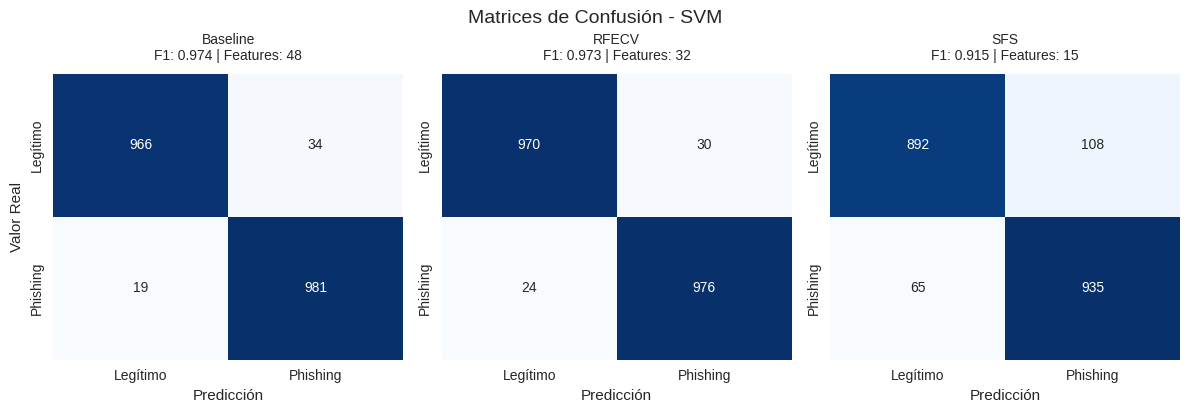


🎯 MEJOR MÉTODO SEGÚN F1-SCORE:
   Método: Baseline
   F1-Score: 0.9737
   Características: 48 de 48
   Top 10 características: ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent']


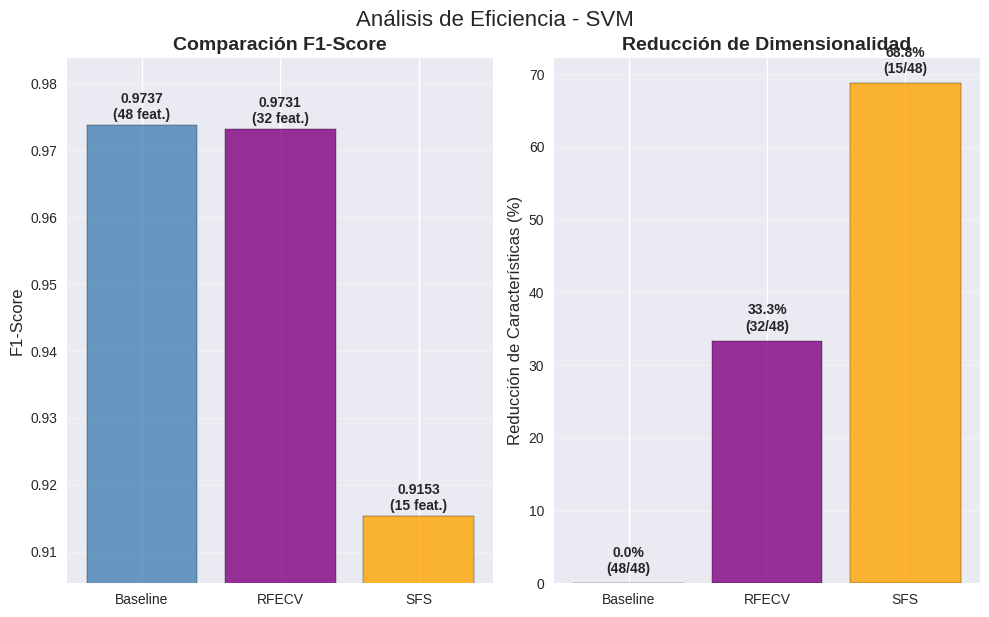

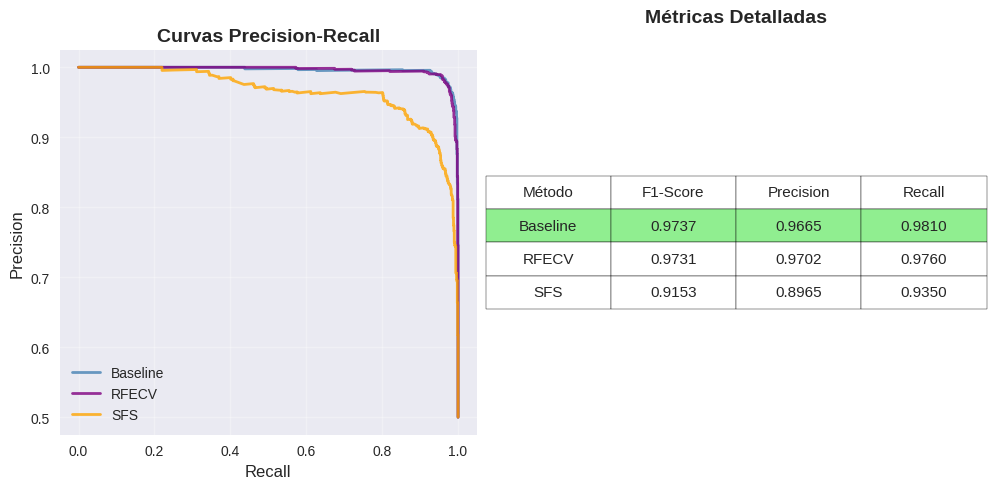


✅ Análisis enfocado completado!


In [15]:
generate_focused_analysis(svm_selector)



🔍 ANÁLISIS ENFOCADO - RF


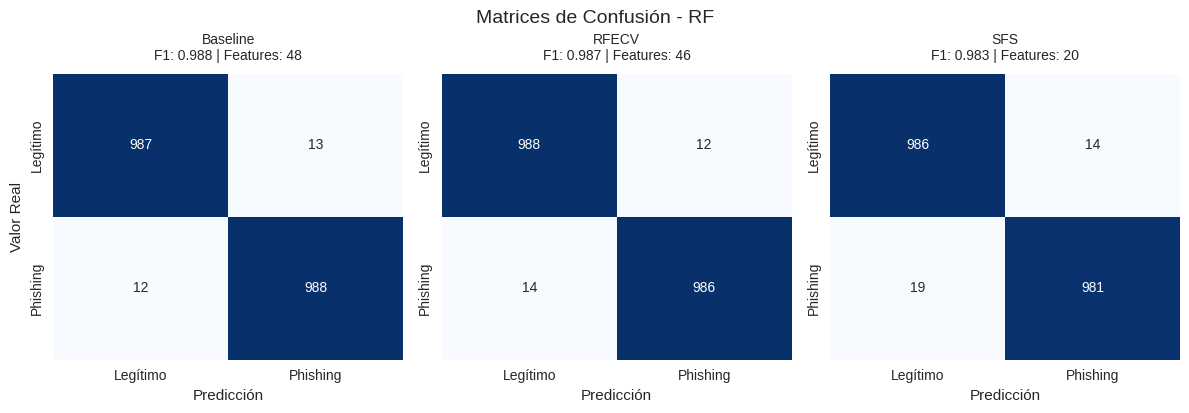


🎯 MEJOR MÉTODO SEGÚN F1-SCORE:
   Método: Baseline
   F1-Score: 0.9875
   Características: 48 de 48
   Top 10 características: ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent']


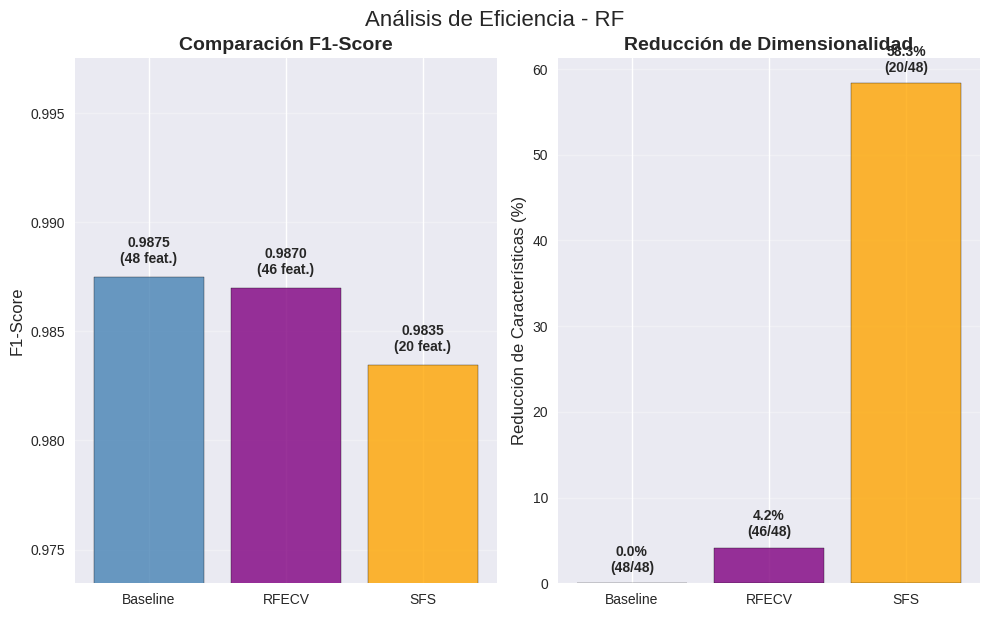

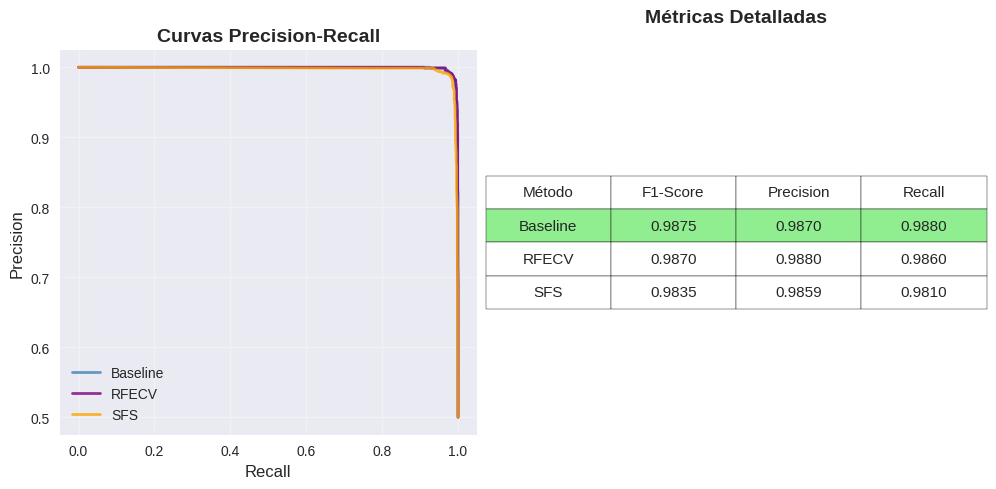


✅ Análisis enfocado completado!


In [16]:
generate_focused_analysis(rf_selector)

---#--

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
import time
warnings.filterwarnings('ignore')

# Configuración global
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 3
SAMPLE_SIZE_SVM = 2000
SAMPLE_SIZE_RF = 3000

# Parámetros optimizados
SVM_PARAMS = {
    'C': 14.403910932208483,
    'kernel': 'rbf',
    'shrinking': True,
    'class_weight': None,
    'gamma': 'scale',
    'random_state': RANDOM_STATE
}

RF_PARAMS = {
    'n_estimators': 157,
    'max_depth': 27,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': False,
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}


In [18]:

def setup_estimators(estimator_type, params):
    """Configura los estimadores según el tipo especificado."""
    if estimator_type == 'svm':
        # Estimador original (RBF)
        estimator_original = SVC(**params)

        # Para selección: SVM lineal
        linear_params = params.copy()
        linear_params['kernel'] = 'linear'
        linear_params.pop('gamma', None)
        estimator_selection = SVC(**linear_params)

    elif estimator_type == 'rf':
        # Mismo estimador para ambos casos
        estimator_original = RandomForestClassifier(**params)
        estimator_selection = RandomForestClassifier(**params)

    return estimator_original, estimator_selection

def evaluate_model(estimator, X_train, X_test, y_train, y_test):
    """Evalúa un modelo y retorna las métricas."""
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    return {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    }


In [19]:
# Cargar dataset
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url).drop(columns=["id"])
X = df.drop(columns=["CLASS_LABEL"])
y = df["CLASS_LABEL"]

print(f"Dataset cargado: {X.shape[0]} muestras, {X.shape[1]} características")

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Configuración de validación cruzada
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"Datos divididos: {X_train.shape[0]} entrenamiento, {X_test.shape[0]} prueba")


Dataset cargado: 10000 muestras, 48 características
Datos divididos: 8000 entrenamiento, 2000 prueba


In [20]:
def prepare_data_for_estimator(estimator_type, X_train, X_test, sample_size):
    """Prepara los datos según el tipo de estimador."""
    results = {}

    if estimator_type == 'svm':
        # Escalamiento para SVM
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        results['scaler'] = scaler
    else:
        # Sin escalamiento para Random Forest
        X_train_scaled = X_train.values
        X_test_scaled = X_test.values
        results['scaler'] = None

    # Muestra para SFS
    sample_size = min(sample_size, len(X_train))
    idx_sample = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train_scaled[idx_sample]
    y_train_sample = y_train.iloc[idx_sample]

    results.update({
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'X_train_sample': X_train_sample,
        'y_train_sample': y_train_sample,
        'sample_size': sample_size
    })

    print(f"Muestra para SFS ({estimator_type}): {sample_size} ejemplos")
    return results


In [21]:
def run_svm_analysis():
    """Ejecuta análisis completo para SVM."""
    print("="*60)
    print("ANÁLISIS SVM")
    print("="*60)

    # Preparar estimadores
    estimator_original, estimator_selection = setup_estimators('svm', SVM_PARAMS)

    # Preparar datos
    data_prep = prepare_data_for_estimator('svm', X_train, X_test, SAMPLE_SIZE_SVM)

    # Baseline
    print("\n1. BASELINE SVM (todas las características)")
    baseline_metrics = evaluate_model(
        estimator_original,
        data_prep['X_train_scaled'],
        data_prep['X_test_scaled'],
        y_train, y_test
    )
    print(f"F1-Score Baseline: {baseline_metrics['f1']:.4f}")

    # RFECV
    print("\n2. RFECV SVM (Recursive Feature Elimination)")
    start_time = time.time()

    rfecv = RFECV(
        estimator=estimator_selection,
        step=1,
        cv=cv,
        scoring="f1",
        n_jobs=1
    )
    rfecv.fit(data_prep['X_train_sample'], data_prep['y_train_sample'])

    # Aplicar selección al dataset completo
    X_train_rfecv = data_prep['X_train_scaled'][:, rfecv.support_]
    X_test_rfecv = data_prep['X_test_scaled'][:, rfecv.support_]

    rfecv_metrics = evaluate_model(
        estimator_original, X_train_rfecv, X_test_rfecv, y_train, y_test
    )

    rfecv_time = time.time() - start_time
    print(f"Tiempo RFECV: {rfecv_time:.1f}s")
    print(f"Características: {X_train_rfecv.shape[1]} de {X.shape[1]} ({100*(1-X_train_rfecv.shape[1]/X.shape[1]):.1f}% reducción)")
    print(f"F1-Score: {rfecv_metrics['f1']:.4f}")

    # SFS
    print("\n3. SFS SVM (Sequential Feature Selection)")
    start_time = time.time()

    max_features = min(15, X.shape[1])
    sfs = SFS(
        estimator_selection,
        k_features=(1, max_features),
        forward=True,
        floating=False,
        scoring='f1',
        cv=cv,
        n_jobs=1
    )

    sfs.fit(data_prep['X_train_sample'], data_prep['y_train_sample'].values)

    # Aplicar selección al dataset completo
    selected_features_sfs = list(sfs.k_feature_idx_)
    X_train_sfs = data_prep['X_train_scaled'][:, selected_features_sfs]
    X_test_sfs = data_prep['X_test_scaled'][:, selected_features_sfs]

    sfs_metrics = evaluate_model(
        estimator_original, X_train_sfs, X_test_sfs, y_train, y_test
    )

    sfs_time = time.time() - start_time
    print(f"Tiempo SFS: {sfs_time:.1f}s")
    print(f"Características: {len(selected_features_sfs)} de {X.shape[1]} ({100*(1-len(selected_features_sfs)/X.shape[1]):.1f}% reducción)")
    print(f"F1-Score: {sfs_metrics['f1']:.4f}")

    return {
        'baseline_metrics': baseline_metrics,
        'rfecv_metrics': rfecv_metrics,
        'sfs_metrics': sfs_metrics,
        'rfecv': rfecv,
        'sfs': sfs,
        'rfecv_time': rfecv_time,
        'sfs_time': sfs_time
    }

# Ejecutar análisis SVM
svm_results = run_svm_analysis()


ANÁLISIS SVM
Muestra para SFS (svm): 2000 ejemplos

1. BASELINE SVM (todas las características)
F1-Score Baseline: 0.9737

2. RFECV SVM (Recursive Feature Elimination)
Tiempo RFECV: 57.9s
Características: 29 de 48 (39.6% reducción)
F1-Score: 0.9746

3. SFS SVM (Sequential Feature Selection)
Tiempo SFS: 234.3s
Características: 14 de 48 (70.8% reducción)
F1-Score: 0.9483


In [22]:
def run_rf_analysis():
    """Ejecuta análisis completo para Random Forest."""
    print("\n" + "="*60)
    print("ANÁLISIS RANDOM FOREST")
    print("="*60)

    # Preparar estimadores
    estimator_original, estimator_selection = setup_estimators('rf', RF_PARAMS)

    # Preparar datos
    data_prep = prepare_data_for_estimator('rf', X_train, X_test, SAMPLE_SIZE_RF)

    # Baseline
    print("\n1. BASELINE RF (todas las características)")
    baseline_metrics = evaluate_model(
        estimator_original,
        data_prep['X_train_scaled'],
        data_prep['X_test_scaled'],
        y_train, y_test
    )
    print(f"F1-Score Baseline: {baseline_metrics['f1']:.4f}")

    # RFECV
    print("\n2. RFECV RF (Recursive Feature Elimination)")
    start_time = time.time()

    rfecv = RFECV(
        estimator=estimator_selection,
        step=1,
        cv=cv,
        scoring="f1",
        n_jobs=1
    )
    rfecv.fit(data_prep['X_train_sample'], data_prep['y_train_sample'])

    # Aplicar selección al dataset completo
    X_train_rfecv = X_train.iloc[:, rfecv.support_]
    X_test_rfecv = X_test.iloc[:, rfecv.support_]

    rfecv_metrics = evaluate_model(
        estimator_original, X_train_rfecv, X_test_rfecv, y_train, y_test
    )

    rfecv_time = time.time() - start_time
    print(f"Tiempo RFECV: {rfecv_time:.1f}s")
    print(f"Características: {X_train_rfecv.shape[1]} de {X.shape[1]} ({100*(1-X_train_rfecv.shape[1]/X.shape[1]):.1f}% reducción)")
    print(f"F1-Score: {rfecv_metrics['f1']:.4f}")

    # SFS
    print("\n3. SFS RF (Sequential Feature Selection)")
    start_time = time.time()

    max_features = min(20, X.shape[1])
    sfs = SFS(
        estimator_selection,
        k_features=(1, max_features),
        forward=True,
        floating=False,
        scoring='f1',
        cv=cv,
        n_jobs=1
    )

    sfs.fit(data_prep['X_train_sample'], data_prep['y_train_sample'].values)

    # Aplicar selección al dataset completo
    selected_features_sfs = list(sfs.k_feature_idx_)
    X_train_sfs = X_train.iloc[:, selected_features_sfs]
    X_test_sfs = X_test.iloc[:, selected_features_sfs]

    sfs_metrics = evaluate_model(
        estimator_original, X_train_sfs, X_test_sfs, y_train, y_test
    )

    sfs_time = time.time() - start_time
    print(f"Tiempo SFS: {sfs_time:.1f}s")
    print(f"Características: {len(selected_features_sfs)} de {X.shape[1]} ({100*(1-len(selected_features_sfs)/X.shape[1]):.1f}% reducción)")
    print(f"F1-Score: {sfs_metrics['f1']:.4f}")

    return {
        'baseline_metrics': baseline_metrics,
        'rfecv_metrics': rfecv_metrics,
        'sfs_metrics': sfs_metrics,
        'rfecv': rfecv,
        'sfs': sfs,
        'rfecv_time': rfecv_time,
        'sfs_time': sfs_time
    }

# Ejecutar análisis Random Forest
rf_results = run_rf_analysis()


ANÁLISIS RANDOM FOREST
Muestra para SFS (rf): 3000 ejemplos

1. BASELINE RF (todas las características)
F1-Score Baseline: 0.9875

2. RFECV RF (Recursive Feature Elimination)
Tiempo RFECV: 131.7s
Características: 43 de 48 (10.4% reducción)
F1-Score: 0.9850

3. SFS RF (Sequential Feature Selection)
Tiempo SFS: 1596.9s
Características: 19 de 48 (60.4% reducción)
F1-Score: 0.9775


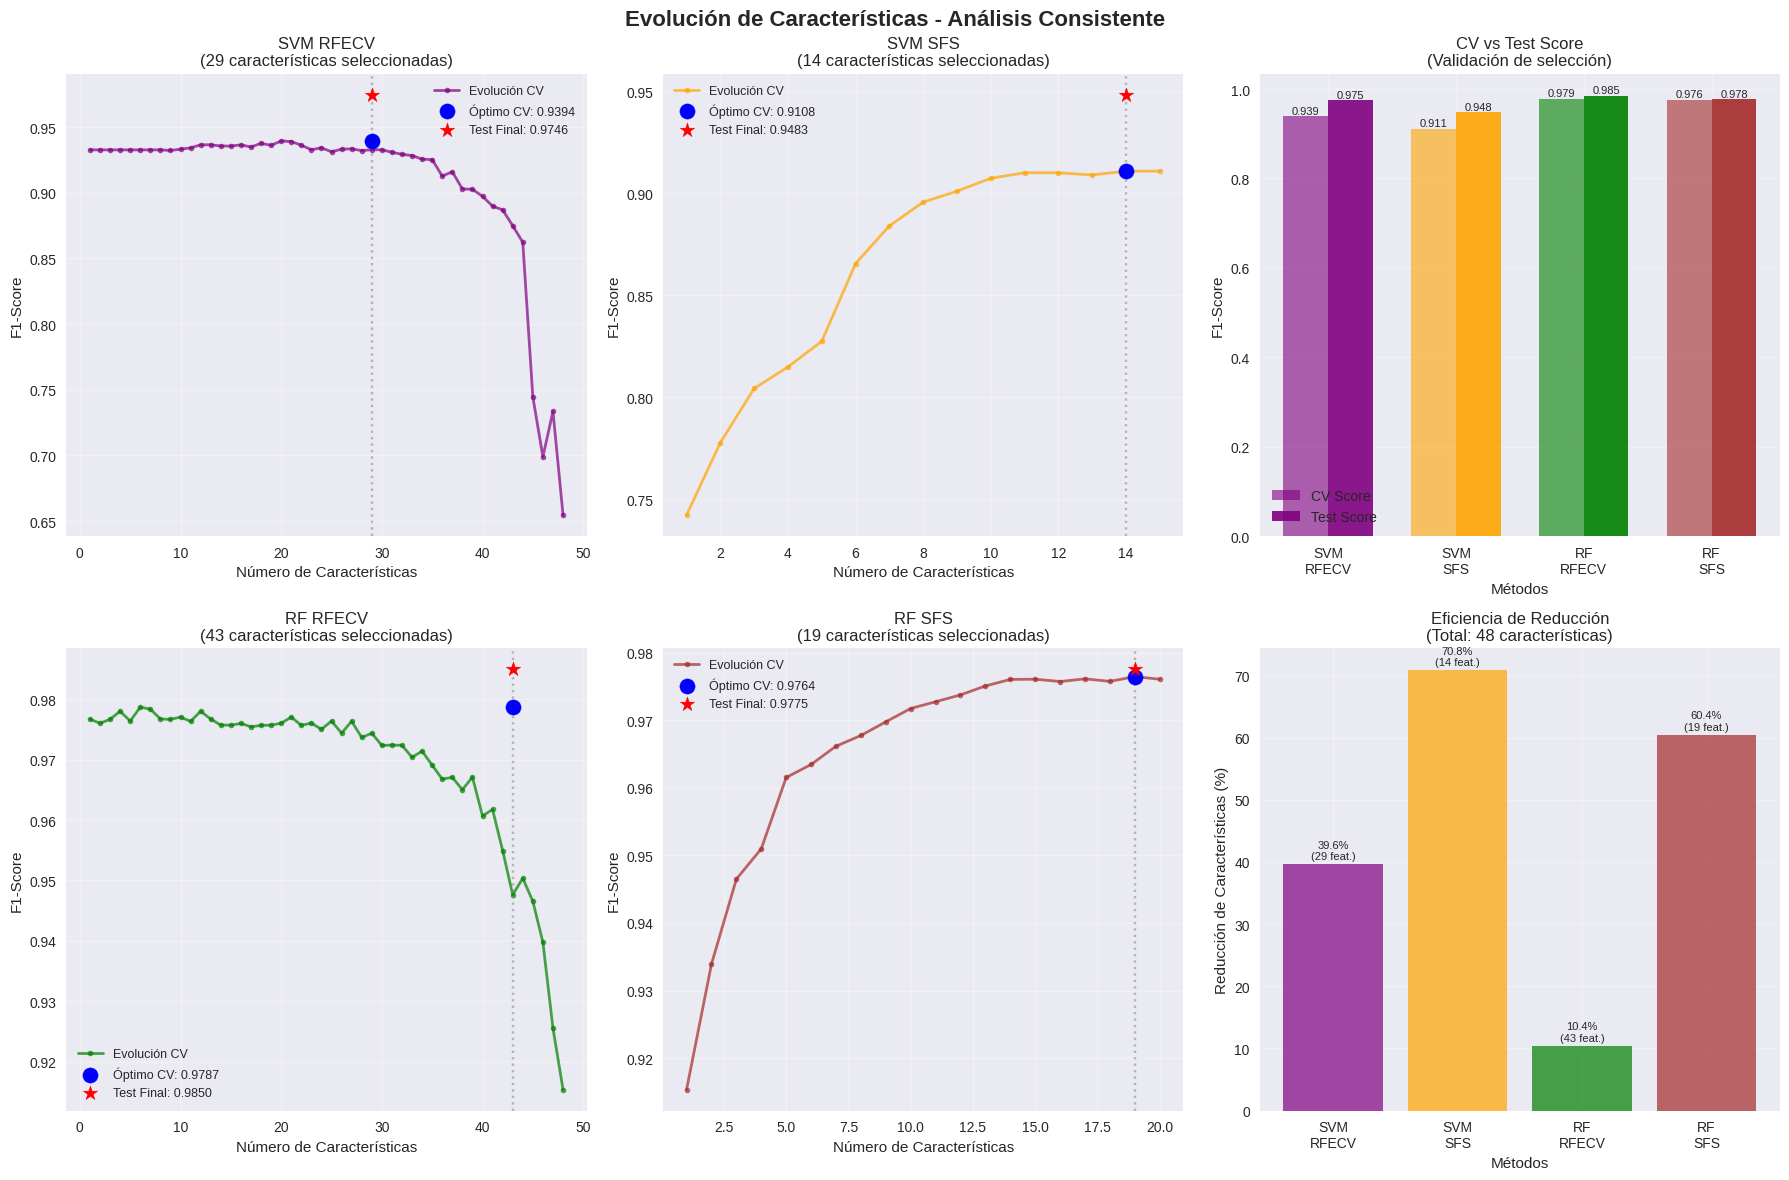


✅ VALIDACIÓN DE CONSISTENCIA:
   ✅ SVM RFECV   : CV=0.9394 → Test=0.9746 (Δ=+0.0352)
   ✅ SVM SFS     : CV=0.9108 → Test=0.9483 (Δ=+0.0374)
   ✅ RF RFECV    : CV=0.9787 → Test=0.9850 (Δ=+0.0063)
   ✅ RF SFS      : CV=0.9764 → Test=0.9775 (Δ=+0.0011)


In [40]:

def plot_consistent_feature_evolution(svm_results, rf_results):
    """
    Visualización consistente que muestra:
    1. Evolución durante CV (proceso de selección)
    2. Punto óptimo seleccionado
    3. Score final en test para validar la selección
    """

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Evolución de Características - Análisis Consistente', fontsize=16, fontweight='bold')

    # Preparar datos SVM
    svm_rfecv_scores = list(svm_results['rfecv'].cv_results_["mean_test_score"])
    svm_rfecv_features = list(range(len(svm_rfecv_scores), 0, -1))
    svm_rfecv_selected = np.sum(svm_results['rfecv'].support_)
    svm_rfecv_cv_score = svm_results['rfecv'].cv_results_["mean_test_score"][svm_rfecv_selected-1]
    svm_rfecv_test_score = svm_results['rfecv_metrics']['f1']

    svm_sfs_dict = svm_results['sfs'].get_metric_dict()
    svm_sfs_scores = [svm_sfs_dict[k]['avg_score'] for k in sorted(svm_sfs_dict.keys())]
    svm_sfs_features = [len(svm_sfs_dict[k]['feature_idx']) for k in sorted(svm_sfs_dict.keys())]
    svm_sfs_selected = len(list(svm_results['sfs'].k_feature_idx_))
    svm_sfs_cv_score = max(svm_sfs_scores)
    svm_sfs_test_score = svm_results['sfs_metrics']['f1']

    # Preparar datos RF
    rf_rfecv_scores = list(rf_results['rfecv'].cv_results_["mean_test_score"])
    rf_rfecv_features = list(range(len(rf_rfecv_scores), 0, -1))
    rf_rfecv_selected = np.sum(rf_results['rfecv'].support_)
    rf_rfecv_cv_score = rf_results['rfecv'].cv_results_["mean_test_score"][rf_rfecv_selected-1]
    rf_rfecv_test_score = rf_results['rfecv_metrics']['f1']

    rf_sfs_dict = rf_results['sfs'].get_metric_dict()
    rf_sfs_scores = [rf_sfs_dict[k]['avg_score'] for k in sorted(rf_sfs_dict.keys())]
    rf_sfs_features = [len(rf_sfs_dict[k]['feature_idx']) for k in sorted(rf_sfs_dict.keys())]
    rf_sfs_selected = len(list(rf_results['sfs'].k_feature_idx_))
    rf_sfs_cv_score = max(rf_sfs_scores)
    rf_sfs_test_score = rf_results['sfs_metrics']['f1']

    # 1. SVM RFECV
    ax1 = axes[0, 0]
    ax1.plot(svm_rfecv_features, svm_rfecv_scores, 'o-',
             color='purple', linewidth=2, markersize=4, alpha=0.7, label='Evolución CV')

    # Punto óptimo durante CV
    ax1.scatter([svm_rfecv_selected], [svm_rfecv_cv_score],
               color='blue', s=120, marker='o', zorder=5,
               label=f'Óptimo CV: {svm_rfecv_cv_score:.4f}')

    # Score final en test
    ax1.scatter([svm_rfecv_selected], [svm_rfecv_test_score],
               color='red', s=120, marker='*', zorder=5,
               label=f'Test Final: {svm_rfecv_test_score:.4f}')

    ax1.axvline(x=svm_rfecv_selected, color='gray', linestyle=':', alpha=0.5)
    ax1.set_xlabel('Número de Características')
    ax1.set_ylabel('F1-Score')
    ax1.set_title(f'SVM RFECV\n({svm_rfecv_selected} características seleccionadas)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9)

    # 2. SVM SFS
    ax2 = axes[0, 1]
    ax2.plot(svm_sfs_features, svm_sfs_scores, 'o-',
             color='orange', linewidth=2, markersize=4, alpha=0.7, label='Evolución CV')

    # Punto óptimo durante CV
    ax2.scatter([svm_sfs_selected], [svm_sfs_cv_score],
               color='blue', s=120, marker='o', zorder=5,
               label=f'Óptimo CV: {svm_sfs_cv_score:.4f}')

    # Score final en test
    ax2.scatter([svm_sfs_selected], [svm_sfs_test_score],
               color='red', s=120, marker='*', zorder=5,
               label=f'Test Final: {svm_sfs_test_score:.4f}')

    ax2.axvline(x=svm_sfs_selected, color='gray', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Número de Características')
    ax2.set_ylabel('F1-Score')
    ax2.set_title(f'SVM SFS\n({svm_sfs_selected} características seleccionadas)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9)

    # 3. RF RFECV
    ax3 = axes[1, 0]
    ax3.plot(rf_rfecv_features, rf_rfecv_scores, 'o-',
             color='green', linewidth=2, markersize=4, alpha=0.7, label='Evolución CV')

    # Punto óptimo durante CV
    ax3.scatter([rf_rfecv_selected], [rf_rfecv_cv_score],
               color='blue', s=120, marker='o', zorder=5,
               label=f'Óptimo CV: {rf_rfecv_cv_score:.4f}')

    # Score final en test
    ax3.scatter([rf_rfecv_selected], [rf_rfecv_test_score],
               color='red', s=120, marker='*', zorder=5,
               label=f'Test Final: {rf_rfecv_test_score:.4f}')

    ax3.axvline(x=rf_rfecv_selected, color='gray', linestyle=':', alpha=0.5)
    ax3.set_xlabel('Número de Características')
    ax3.set_ylabel('F1-Score')
    ax3.set_title(f'RF RFECV\n({rf_rfecv_selected} características seleccionadas)')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)

    # 4. RF SFS
    ax4 = axes[1, 1]
    ax4.plot(rf_sfs_features, rf_sfs_scores, 'o-',
             color='brown', linewidth=2, markersize=4, alpha=0.7, label='Evolución CV')

    # Punto óptimo durante CV
    ax4.scatter([rf_sfs_selected], [rf_sfs_cv_score],
               color='blue', s=120, marker='o', zorder=5,
               label=f'Óptimo CV: {rf_sfs_cv_score:.4f}')

    # Score final en test
    ax4.scatter([rf_sfs_selected], [rf_sfs_test_score],
               color='red', s=120, marker='*', zorder=5,
               label=f'Test Final: {rf_sfs_test_score:.4f}')

    ax4.axvline(x=rf_sfs_selected, color='gray', linestyle=':', alpha=0.5)
    ax4.set_xlabel('Número de Características')
    ax4.set_ylabel('F1-Score')
    ax4.set_title(f'RF SFS\n({rf_sfs_selected} características seleccionadas)')
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=9)

    # 5. Comparación de Mejora Test vs CV
    ax5 = axes[0, 2]
    methods = ['SVM\nRFECV', 'SVM\nSFS', 'RF\nRFECV', 'RF\nSFS']
    cv_scores = [svm_rfecv_cv_score, svm_sfs_cv_score, rf_rfecv_cv_score, rf_sfs_cv_score]
    test_scores = [svm_rfecv_test_score, svm_sfs_test_score, rf_rfecv_test_score, rf_sfs_test_score]

    x_pos = np.arange(len(methods))
    width = 0.35

    bars1 = ax5.bar(x_pos - width/2, cv_scores, width, label='CV Score',
                    color=['purple', 'orange', 'green', 'brown'], alpha=0.6)
    bars2 = ax5.bar(x_pos + width/2, test_scores, width, label='Test Score',
                    color=['purple', 'orange', 'green', 'brown'], alpha=0.9)

    ax5.set_xlabel('Métodos')
    ax5.set_ylabel('F1-Score')
    ax5.set_title('CV vs Test Score\n(Validación de selección)')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(methods)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Añadir valores en las barras
    for bar, score in zip(bars1, cv_scores):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{score:.3f}', ha='center', va='bottom', fontsize=8)

    for bar, score in zip(bars2, test_scores):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{score:.3f}', ha='center', va='bottom', fontsize=8)

    # 6. Resumen de reducción
    ax6 = axes[1, 2]
    n_features_selected = [svm_rfecv_selected, svm_sfs_selected, rf_rfecv_selected, rf_sfs_selected]
    total_features = X.shape[1]
    reduction_pct = [100 * (1 - n/total_features) for n in n_features_selected]

    colors = ['purple', 'orange', 'green', 'brown']
    bars = ax6.bar(methods, reduction_pct, color=colors, alpha=0.7)

    ax6.set_xlabel('Métodos')
    ax6.set_ylabel('Reducción de Características (%)')
    ax6.set_title(f'Eficiencia de Reducción\n(Total: {total_features} características)')
    ax6.grid(True, alpha=0.3)

    # Añadir valores en las barras
    for bar, pct, n_feat in zip(bars, reduction_pct, n_features_selected):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%\n({n_feat} feat.)',
                ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Validación de consistencia
    print(f"\n✅ VALIDACIÓN DE CONSISTENCIA:")
    methods_check = [
        ("SVM RFECV", svm_rfecv_test_score, svm_rfecv_cv_score),
        ("SVM SFS", svm_sfs_test_score, svm_sfs_cv_score),
        ("RF RFECV", rf_rfecv_test_score, rf_rfecv_cv_score),
        ("RF SFS", rf_sfs_test_score, rf_sfs_cv_score)
    ]

    for method, test_score, cv_score in methods_check:
        diff = test_score - cv_score
        status = "✅" if diff >= 0 else "⚠️"
        print(f"   {status} {method:12}: CV={cv_score:.4f} → Test={test_score:.4f} (Δ={diff:+.4f})")


plot_consistent_feature_evolution(svm_results, rf_results)

In [24]:
def print_final_summary(svm_results, rf_results):
    """Imprime resumen final de todos los análisis."""

    print("\n" + "="*80)
    print("RESUMEN FINAL DE RESULTADOS")
    print("="*80)

    # Crear tabla comparativa
    results_data = {
        'Método': [
            'SVM Baseline', 'SVM + RFECV', 'SVM + SFS',
            'RF Baseline', 'RF + RFECV', 'RF + SFS'
        ],
        'F1_Score': [
            svm_results['baseline_metrics']['f1'],
            svm_results['rfecv_metrics']['f1'],
            svm_results['sfs_metrics']['f1'],
            rf_results['baseline_metrics']['f1'],
            rf_results['rfecv_metrics']['f1'],
            rf_results['sfs_metrics']['f1']
        ],
        'Características': [
            X.shape[1],
            np.sum(svm_results['rfecv'].support_),
            len(list(svm_results['sfs'].k_feature_idx_)),
            X.shape[1],
            np.sum(rf_results['rfecv'].support_),
            len(list(rf_results['sfs'].k_feature_idx_))
        ],
        'Tiempo_s': [
            0, svm_results['rfecv_time'], svm_results['sfs_time'],
            0, rf_results['rfecv_time'], rf_results['sfs_time']
        ]
    }

    results_df = pd.DataFrame(results_data)
    results_df['Reducción_%'] = 100 * (1 - results_df['Características'] / X.shape[1])

    print("\nTABLA COMPARATIVA:")
    print(results_df.round(4))

    # Mejor método
    best_idx = results_df['F1_Score'].idxmax()
    best_method = results_df.loc[best_idx]

    print(f"\n🏆 MEJOR MÉTODO:")
    print(f"   Método: {best_method['Método']}")
    print(f"   F1-Score: {best_method['F1_Score']:.4f}")
    print(f"   Características: {int(best_method['Características'])} de {X.shape[1]} ({best_method['Reducción_%']:.1f}% reducción)")
    print(f"   Tiempo: {best_method['Tiempo_s']:.1f}s")

    print("\n💡 CARACTERÍSTICAS SELECCIONADAS:")
    svm_rfecv_features = [X.columns[i] for i in range(len(X.columns)) if svm_results['rfecv'].support_[i]]
    svm_sfs_features = [X.columns[i] for i in list(svm_results['sfs'].k_feature_idx_)]
    rf_rfecv_features = [X.columns[i] for i in range(len(X.columns)) if rf_results['rfecv'].support_[i]]
    rf_sfs_features = [X.columns[i] for i in list(rf_results['sfs'].k_feature_idx_)]

    print(f"SVM RFECV ({len(svm_rfecv_features)}): {svm_rfecv_features}")
    print(f"SVM SFS ({len(svm_sfs_features)}): {svm_sfs_features}")
    print(f"RF RFECV ({len(rf_rfecv_features)}): {rf_rfecv_features}")
    print(f"RF SFS ({len(rf_sfs_features)}): {rf_sfs_features}")

    print("\n" + "="*80)

# Ejecutar resumen final
print_final_summary(svm_results, rf_results)


RESUMEN FINAL DE RESULTADOS

TABLA COMPARATIVA:
         Método  F1_Score  Características   Tiempo_s  Reducción_%
0  SVM Baseline    0.9737               48     0.0000       0.0000
1   SVM + RFECV    0.9746               29    57.9429      39.5833
2     SVM + SFS    0.9483               14   234.2726      70.8333
3   RF Baseline    0.9875               48     0.0000       0.0000
4    RF + RFECV    0.9850               43   131.6813      10.4167
5      RF + SFS    0.9775               19  1596.9278      60.4167

🏆 MEJOR MÉTODO:
   Método: RF Baseline
   F1-Score: 0.9875
   Características: 48 de 48 (0.0% reducción)
   Tiempo: 0.0s

💡 CARACTERÍSTICAS SELECCIONADAS:
SVM RFECV (29): ['NumDots', 'SubdomainLevel', 'PathLevel', 'NumDash', 'NumDashInHostname', 'TildeSymbol', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NoHttps', 'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'ExtFormAction',